# Assigment 2 - Batch Processing
---

##### <font color='#e52425'>Please fill out your name and StudentID here:</font>

Your Name: Md Majharul Islam Nayem

StudentID: stu218568

##### The next Tutorial will take place online on Friday, Dec 18th 2020 at 11:00am (CET) c.t. <br><br>This Assignment is due on Monday, Jan 11th 2021 at 11:59pm (CET)<br>We wish you a merry Christmas and a happy new year 2021!

| Total Points | Points Needed To Pass (50%) | Points Reached |
|:-:|:-:|:-----------:|
| 10 | 5 |  |

Hello there! This is the second Assignment for Big Data Management and Analytics. We will take a closer look on how to implement various algorithms using the Map-Reduce programming model.

As in all assignments, we marked every part, where you have to add something with a <font color='#782769'> purple TODO</font>, the <font color='#e52425'>graded parts are marked in red</font> and are mandatory to submit to take part in the exam, so please read the assignment carefully!

## Goals

This lecture is called "Big Data Management and Analytics", so when are we gonna use "BIG Data"? Well this is easier said than done because first of all, you guys probably only have one, maximum two or three, machines at hand and secondly, you need to make sure that multiple machines working on a common task sync and communicate with each other correctly to get a result.

The latter is the main topic of this assignment. We want to give you guys practical examples of known algorithms using the map-reduce programming model which then could be easily distributed over various machines using a distributed file system like Hadoop. Each machine (now called a worker) then computes a small part of the given data and in the end the individual results are merged (collected, reduced) into a single result.

## Step 0 - Setup

As always, the are a few things needed to be installed when working with distributed data. Because we will still only work on one machine, we do not need an actual framework like Apache Spark, but we will use pyspark, which is usually the bridge between Python and the actual Spark framework. Pyspark is written in Scala, which is a Java dialect and therefore you need to have Java installed on your machine to use pyspark.

If you don't, you can download the SDK [ here ]( https://www.oracle.com/de/java/technologies/javase-jdk15-downloads.html ) and remember to update your PATH variable and restart afterwards!

Now, first install pyspark using whatever method you prefer, here is the pip comand:

In [1]:
%pip install pyspark
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

os.environ["PYSPARK_PYTHON"]="python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="python3"

Next, let's import everything we will need for the first example.

In [2]:
from pyspark import SparkConf, SparkContext
import numpy as np

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

Now we configure the Spark environment. This Context (_sc_) will be used everytime we parallelize tasks.

In [3]:
# Configure the Spark environment
sparkConf = (SparkConf()
             .setAppName("Ass2")
             .setMaster("local"))
sc = SparkContext.getOrCreate(conf=sparkConf)
print(sc.version)

3.0.1


## Example 1 - Word Count

Word Count is a very simple task, that is easily parallelized. The goal is to count the occurences of the different words in a text. We will use the same tounge twister sentence from the lecture:

In [4]:
tounge_twister = "How much ground would a groundhog hog if a groundhog could hog ground \
A groundhog would hog all the ground he could hog if a groundhog could hog ground"

Because we want to ignore capitalization of the words at the beginning of the sentence, we first convert the whole string to lower case and then split the text whenever there is a space. Note, that we only show the first 5 words for clarity.

In [5]:
tounge_twister = tounge_twister.lower().split(" ")
tounge_twister[:5]

['how', 'much', 'ground', 'would', 'a']

Spark revolves around the concept of a resilient distributed dataset (RDD), which is a fault-tolerant collection of elements that can be operated on in parallel. Admittedly this is a little outdated and today dataframes are also frequently used but again for simplicity and to stay consistent with what most companies still use, we stick to RDDs for now.

Now this RDD creation can be done in two ways, you can refer to an external dataset present locally on the file system's machines or, you can parallelize an existing collection using _sc.parallelize_.
Because we are only pretending to work on a multi-machine system, we will parallelize our data without actually distributing it.

In [6]:
words2 = sc.parallelize(tounge_twister) 

Now, the actual Map-Reduce part begins. We want to **map** every single word as a key to the occurrence as value. The occurrence is of course 1 for every single word. Again, we shortened the list to the first 5 entries but feel free to look at the entire list to understand better, what's going on.

In [7]:
wordsMapped2 = words2.map(lambda word: (word,1)) #assign key to each word 
wordsMapped2.collect()[:5]

[('how', 1), ('much', 1), ('ground', 1), ('would', 1), ('a', 1)]

Next, we want to **reduce** the entries by key, meaning the same words should be summarized in one entry and the number should show how often that word appeared in the sentence.

In [8]:
wordCount2 = wordsMapped2.reduceByKey(lambda c1, c2: c1 + c2) #returns RDD object 

That's it! Easy, right? Now, let's return the result:

In [9]:
print('Number of occurences per word: ', wordCount2.collect())

Number of occurences per word:  [('how', 1), ('much', 1), ('ground', 4), ('would', 2), ('a', 4), ('groundhog', 4), ('hog', 5), ('if', 2), ('could', 3), ('all', 1), ('the', 1), ('he', 1)]


## Example 2 - Matrix Multiplication

The next example is a little more complex. We want to parallelize the multiplication of two matrices.

In [10]:
from bdma.util import makeTuple, makeMatrix

We have two matrices here:

$
A = 
\begin{pmatrix}
1 & 2 & 3\\
4 & 5 & 6
\end{pmatrix}
~$
and 
$
~B = 
\begin{pmatrix}
7 & 8 \\
9 & 10 \\
11 & 12
\end{pmatrix}
$

We want to calculate the product of those two ($A \times B$)

In [11]:
A = np.array([[1, 2, 3], [4, 5, 6]])
B = np.array([[7, 8], [9, 10], [11, 12]])

First we need to transform each entry in the matrix $a_{ij}$ and $b_{jk}$ into a tuple. In the _util.py_ file we prepared a function which will take a matrix and its name and transforms it into separate tuples. 

I.e., the tuple look like this: $('a', 1, 0, 4)$

The first element is the name you gave as a parameter and will be used to identify from which matrix the tuple is coming from. The next two elements are $i$ and $j$, the position within the matrix the value was located (Note that in matrix $B$ we call them $j$ and $k$!) and the last element is the actual value of the position $a_{ij}$, here it's $4$.

In [12]:
mxA = sc.parallelize(makeTuple(A, 'a'))
mxB = sc.parallelize(makeTuple(B, 'b'))
mxA.collect()

[('a', 0, 0, 1),
 ('a', 0, 1, 2),
 ('a', 0, 2, 3),
 ('a', 1, 0, 4),
 ('a', 1, 1, 5),
 ('a', 1, 2, 6)]

### <font color='#782769'>Now it's your turn!<br> TODO #1:</font>
### <font color='#e52425'>This will be graded. You can reach a total of 2 points</font>

Now, when multiplying two matrices, we want to match up the rows of matrix $A$ with the columns of matrix $B$. This is the reason, we refer to the positions as $a_{ij}$ and $b_{jk}$, so $j$ is the key for solving this here, pun intended. :D

## TODO#1: 
#  Map the tuples you've got to a key, value pair, where j is the key, and the other three elements are the value.
#  So, ('a', i, j, a_ij) to (j, ('a', i, a_ij) 
#  and ('b', j, k, b_jk) to (j, ('b', k, b_jk))
#  you can do this however you want, we would recomend using a lambda function.

mxA_zip = ...
mxB_zip = ...
mxA_zip.collect()

Your result for matrix $A$ should look like this:
```python
[(0, ('a', 0, 1)),
 (1, ('a', 0, 2)),
 (2, ('a', 0, 3)),
 (0, ('a', 1, 4)),
 (1, ('a', 1, 5)),
 (2, ('a', 1, 6))]
```

Now, we want to join the tuples with the same key. With this we will get every combination for each key. For key '0' for example we have two entries in $A$ and two entries in $B$, so we will get a total of 4 entries with every combination possible.

In [13]:
## Joined tuples (j, [('a', i, a_ij),('b', k, b_jk)])
mxA_zip = sc.parallelize([ item for elm in map(lambda x,i: list(map(lambda y, j: (j,('a',i,A[i][j])), x, range(len(x)))), A, range(len(A))) for item in elm])
mxB_zip = sc.parallelize([ item for elm in map(lambda x,j: list(map(lambda y, k: (j,('a',k,B[j][k])), x, range(len(x)))), B, range(len(B))) for item in elm])

mxJoined = mxA_zip.join(mxB_zip)
mxJoined.collect()

[(0, (('a', 0, 1), ('a', 0, 7))),
 (0, (('a', 0, 1), ('a', 1, 8))),
 (0, (('a', 1, 4), ('a', 0, 7))),
 (0, (('a', 1, 4), ('a', 1, 8))),
 (2, (('a', 0, 3), ('a', 0, 11))),
 (2, (('a', 0, 3), ('a', 1, 12))),
 (2, (('a', 1, 6), ('a', 0, 11))),
 (2, (('a', 1, 6), ('a', 1, 12))),
 (1, (('a', 0, 2), ('a', 0, 9))),
 (1, (('a', 0, 2), ('a', 1, 10))),
 (1, (('a', 1, 5), ('a', 0, 9))),
 (1, (('a', 1, 5), ('a', 1, 10)))]

The next step is the elementwise multiplication of the values within the joined tuples. After this multiplication, the position $j$ is irrelevant for our numbers, so we also need to re-map the tuples to another key.
Now the $i$ and $k$ come into play.

### <font color='#782769'>Now it's your turn!<br> TODO #2:</font>
### <font color='#e52425'>This will be graded. You can reach a total of 2 points</font>

In [14]:
## TODO#2: 
#  Now map the tuples onto a 2-tuple (i,k) as key and the 
#  product of a_ij and b_jk as value.
# (j, [('a', i, a_ij),('b', k, b_jk)]) -> ((i, k), (a_ij*b_jk))


mxProducts = sc.parallelize(map(lambda x: ((x[1][0][1],x[1][1][1]),x[1][0][2]*x[1][1][2]), mxJoined.collect()))
mxProducts.collect()

[((0, 0), 7),
 ((0, 1), 8),
 ((1, 0), 28),
 ((1, 1), 32),
 ((0, 0), 33),
 ((0, 1), 36),
 ((1, 0), 66),
 ((1, 1), 72),
 ((0, 0), 18),
 ((0, 1), 20),
 ((1, 0), 45),
 ((1, 1), 50)]

Your result should look like this:
```python
[((0, 0), 7),
 ((0, 1), 8),
 ((1, 0), 28),
 ((1, 1), 32),
 ((0, 0), 33),
 ((0, 1), 36),
 ((1, 0), 66),
 ((1, 1), 72),
 ((0, 0), 18),
 ((0, 1), 20),
 ((1, 0), 45),
 ((1, 1), 50)]
```

All that is left to do now, is to reduce by key and sum up over all tuples with the same key-tuple.

### <font color='#782769'><br>Now it's your turn!<br>TODO #3:</font>
### <font color='#e52425'>This will be graded. You can reach a total of 1 point</font>

In [15]:
mxC = mxProducts.reduceByKey(lambda x,y: x + y)

In [16]:
makeMatrix(mxC.collect(), 2, 2) #parameters: tuples, rows of output matrix, columns

array([[ 58.,  64.],
       [139., 154.]])

You can use the _makeMatrix_ function from the _util.py_ to display the matrix.
If everything worked correctly the final result should be:
$
C = 
\begin{pmatrix}
58 & 64 \\
139 & 154 
\end{pmatrix}
$

Now, even if the matices would be bigger than the storage of one machine, with this method you'd still be able to calculate the product simply by generating all these tuples, and distributing them by key to certain machines. After they did the joining and multiplying of their parts, all resulting tuples can be collected, summed up and returned as one final matrix.

## Example 3 - K-Means 

Last but not least we want to take a look at the probably most common unsupervised classification algorithm: k-Means

Let's consider a typical, totally realistic scenario:

Santa Claus collected data from all over the world (which should be way more than what could fit on one machine btw^^). He needs to distribute his workload this year to his reindeers because Covid19 has him grounded and he is not allowed to leave the northpole for now.
To find the most efficient way of dividing the world into pieces (clusters), he runs a k-Means algorithm on his data, where $k=9$, because that's the number of reindeer he's got.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as sci
import re
import pandas as pd
from bdma.kmeans import saveResultForIteration

To keep it feasible for you guys, we will filter out all tiny towns or cities with less than 10000 people. Note, this is only for computing k_means and dividing the world into 9 clusters, they will still get their presents of course!

In [18]:
data = pd.read_csv('./data/worldcities.csv')
data = data[data['population'] > 10000]
data.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140


If we scatter the cities, marked by latitude and longitude, the picture already looks kinda familiar:

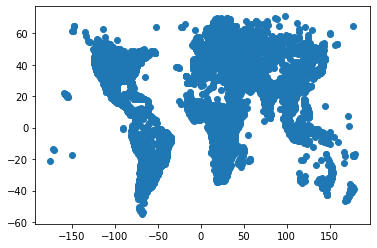

In [19]:
%matplotlib inline
cities = data[['lng', 'lat']].values
plt.scatter(cities[:, 0], cities[:, 1])

And then let's break the data into parts to execute in parallel.

In [20]:
p_points = sc.parallelize(cities) #rdd object for point list

Now, let's initialize the k-Means algorithm with its centers.

In [21]:
k = 9 #number of clusters
no_iter = 15 #number of iterations

#initialize k centroids
centroids = p_points.takeSample(False, k)
#print(centroids)

#list of intermediate centroids, only saved for plotting
intermed_centroids = []
intermed_centroids.append(centroids)

# save intermediate results for plotting
result_i = dict() #result of iteration i

The next part will be the two functions we will need for a basic k-Means algorithm. We calculate the distances of points to all centroids and assign the points to their closest centroid in the *assign_to_centroid* function. Afterwards we calculate the mean value of all the points in one cluster and thake that result as the new cluster center (*calculate_new_centroid*). Make yourself familiar with the code, shouldn't be anything new here. 

### <font color='#782769'><br>Now it's your turn!<br>TODO #4:</font>
### <font color='#e52425'>This will be graded. You can reach a total of 1+1=2 points</font>

In [22]:
# calculates distances of point to all centroids and assigns point to closest centroid
def assign_to_centroid(point):
    bestCentroid = None
    minDist = float('inf')
    
    ## TODO#4.1 (1 point): Calculate the distance
    #  from a point to all centroids and save the
    #  best (closest) one.
    #  Hint: There are functions for calculating eucledean
    #  distances such as sci.distance.euclidean(x1, x2)
    
    for index in range(len(centroids)):
        centroid = centroids[index]
        distance = sci.distance.euclidean(point, centroid)
        
        if distance < minDist:
            minDist = distance
            bestCentroid = index
    
    return (bestCentroid, point)

# calculates mean of points in a cluster and returns it as new centroid
def calculate_new_centroid(*cluster_points):
    sum_vector = [0, 0]
    n = 0 #number of points in cluster
    
    ## TODO#4.2 (1 point): Add the for-loop here to return the new centroid
    #  for ...
    
    for index in range(len(cluster_points)):
        cpoint = cluster_points[index]
        sum_vector = sum_vector + cpoint
        n += 1
    
    return sum_vector/n

As mentioned in the lecture, we will now use the classifying, so the assigning of points to their cluster as the **map** task and the recentering of the centroids as the **reduce** task. We will always calculate a value $\delta$ (*delta*) to keep track if the centroids moved and if they didn't, we will terminate the algorithm.

### <font color='#782769'><br>Now it's your turn!<br>TODO #5:</font>
### <font color='#e52425'>This will be graded. You can reach a total of 1+1+1=3 points</font>

In [23]:
j = 0
delta = float('inf')

while delta > 0:
    print('ITERATION ', j+1)
    
    ## TODO#5.1 (1 point): Map the points to their
    #  respective centroids using the function above
    #  point -> (clusterID, point)
    
    assignments = p_points.map(assign_to_centroid)
    assigned = assignments.collect()
    
    saveResultForIteration(result_i, j, assigned) #for plotting
    
    ## TODO#5.2 (1 point): Reduce by calculating the
    #  new centroid with the function above
    #  (clusterID, [p1, p2,..]) -> (clusterID, new centroid)
    
    c_new = assignments.reduceByKey(calculate_new_centroid)
    
    centroids_new = [c[1] for c in c_new.collect()] #get new centroids
    print('New Centroids: ', centroids_new)

    ## TODO#5.3 (1 point): Calculate the difference between the
    #  old centroids and the new ones to check if another 
    #  iteration is needed 
    
    delta = 0
    for i in range(k):
        delta = delta + sci.distance.euclidean(centroids_new[i],centroids[i])
    print('Delta: ', delta)

    centroids = centroids_new #use new centroids for next iteration
    intermed_centroids.append(centroids) #just for plotting

    j += 1

ITERATION  1
New Centroids:  [array([135.64765834,  43.39718568]), array([51.20582246, -0.61533486]), array([-68.08379783, -20.92768784]), array([-103.05379238,   41.6426291 ]), array([27.11278594,  2.50601282]), array([ 7.71855771, 48.87741465]), array([51.53230023, 53.88842805]), array([28.30244631, 61.54225341]), array([14.26721456, 50.80410393])]
Delta:  733.450094011188
ITERATION  2
New Centroids:  [array([135.64761995,  43.39719827]), array([69.09630436, 13.1391567 ]), array([50.46618654, 55.66554801]), array([-68.15423556, -20.9206443 ]), array([-103.05379238,   41.6426291 ]), array([21.96337565, 46.78839625]), array([28.64160359, 61.59651598]), array([26.09816058, -9.79928776]), array([ 7.79352161, 49.10803081])]
Delta:  487.8875553964821
ITERATION  3
New Centroids:  [array([135.64766108,  43.39718411]), array([87.7060813 , 13.39723493]), array([-68.15423556, -20.9206443 ]), array([-103.05379238,   41.6426291 ]), array([25.31751329, 45.37023106]), array([28.64085599, 61.6148223

And that's it! Santa does need a map though because reindeer are not very mathematically talented, so below you can find code to plot your iterations and take a look at it. As you can see, the result will probably result in some workload-complains and possibly some discussion about fairness in distributing but hey, at least it was computed in time for Christmas!

With that said, **have a nice winter break and holidays**, see you guys next year! :)

Iteration:  1


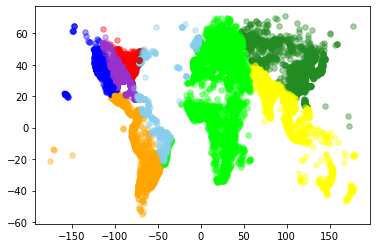

Iteration:  2


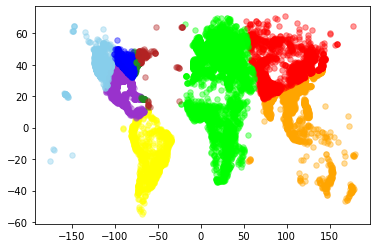

Iteration:  3


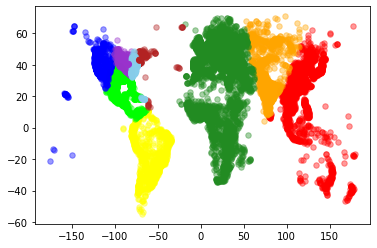

Iteration:  4


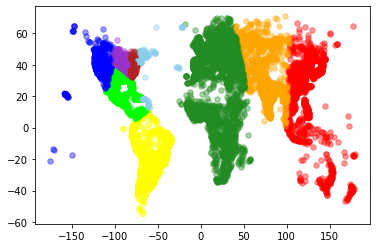

Iteration:  5


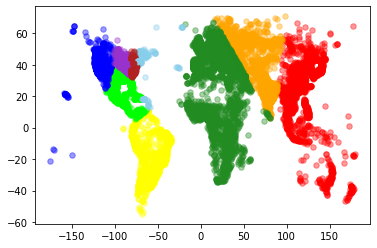

Iteration:  6


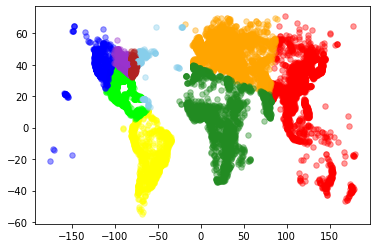

Iteration:  7


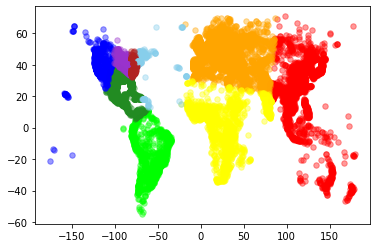

In [24]:
# Plotting
%matplotlib inline

curr_pos = 0 #iteration
fig = plt.figure()
ax1 = fig.add_subplot(111)
colors = ['red', 'orange', 'yellow', 'lime', 'forestgreen', 'skyblue', 'blue', 'darkorchid', 'firebrick']

for i in range(1, j):
    ax1.cla()

    print("Iteration: ", curr_pos+1)
    #Points
    for clusterID in result_i[curr_pos].keys():
        plt.scatter(result_i[curr_pos][clusterID].x, result_i[curr_pos][clusterID].y, s=30, c=colors[clusterID], alpha=0.4)

    #Centroids
    xArr = []
    yArr = []
    centroid_colors = []
    for i in range (0, len(intermed_centroids[curr_pos])):
        xArr.append(intermed_centroids[curr_pos][i][0])
        yArr.append(intermed_centroids[curr_pos][i][1])
        centroid_colors.append(colors[i])

    plt.scatter(xArr, yArr, s=40, c=centroid_colors)
    plt.show()
    
    curr_pos += 1